<a href="https://www.kaggle.com/code/stukst/credit-card-fraud-detection?scriptVersionId=219938076" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/fraud-detection/fraudTest.csv
/kaggle/input/fraud-detection/fraudTrain.csv


# Step1: **Import Neccesarry Libraries**

In [2]:
import pandas as pd
import numpy as np

# Step2: **Load the Dataset**

In [3]:
fraud_test = pd.read_csv('/kaggle/input/fraud-detection/fraudTest.csv')
fraud_train = pd.read_csv('/kaggle/input/fraud-detection/fraudTrain.csv')
print('Fraud Training Dataset: ')
fraud_train.head()
# print('Fraud Testing Dataset: ')
# fraud_test.head()

Fraud Training Dataset: 


,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,...,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,...,36.0788,-81.1781,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0
1,1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,...,48.8878,-118.2105,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0
2,2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,...,42.1808,-112.2620,4154,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.150704,-112.154481,0
3,3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,...,46.2306,-112.1138,1939,Patent attorney,1967-01-12,6b849c168bdad6f867558c3793159a81,1325376076,47.034331,-112.561071,0
4,4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,...,38.4207,-79.4629,99,Dance movement psychotherapist,1986-03-28,a41d7549acf90789359a9aa5346dcb46,1325376186,38.674999,-78.632459,0


# Step3: **Preprocess the Data**

## Handling Missing Data

In [4]:
def check_missing_value_percent(df):
    missing_values_count = fraud_train.isnull().sum()
    missing_values_percentage = (missing_values_count / len(df)) * 100
    print('Missing values %: ', missing_values_percentage)
    return missing_values_percentage

In [5]:
def handle_missing_values(df):
    percent = check_missing_value_percent(df)
    print('Missing Values Percentage:\n', percent)

    # check if there are any missing values
    if percent.sum() == 0:
        print('No handling is needed!')
    else:
        # Handle missing values
        for col in df.columns:
            if df[col].dtype in ['float64', 'int64']:    # Numeric columns
                df[col].fillna(df[col].mean(), inplace=True)
            else:    # Categorical columns
                df[col].fillna(df[col].mode()[0], inplace=True)
                
    # elif percent < 20:
    #     deletion(df)
    # else:
    #     knn_imputation(df)
    # But since, missing value % = 0.0, No imputation is needed.

    return df

In [6]:
fraud_train = handle_missing_values(fraud_train)
fraud_test = handle_missing_values(fraud_test)

Missing values %:  Unnamed: 0               0.0
trans_date_trans_time    0.0
cc_num                   0.0
merchant                 0.0
category                 0.0
amt                      0.0
first                    0.0
last                     0.0
gender                   0.0
street                   0.0
city                     0.0
state                    0.0
zip                      0.0
lat                      0.0
long                     0.0
city_pop                 0.0
job                      0.0
dob                      0.0
trans_num                0.0
unix_time                0.0
merch_lat                0.0
merch_long               0.0
is_fraud                 0.0
dtype: float64
Missing Values Percentage:
 Unnamed: 0               0.0
trans_date_trans_time    0.0
cc_num                   0.0
merchant                 0.0
category                 0.0
amt                      0.0
first                    0.0
last                     0.0
gender                   0.0
street    

### Remove Duplicate Transactions

#### Identify Duplicate Transactions

In [7]:
train_duplicates = fraud_train[fraud_train.duplicated(subset=['trans_date_trans_time', 'cc_num', 'amt', 'merchant', 'trans_num'], keep=False)]
test_duplicates = fraud_test[fraud_test.duplicated(subset=['trans_date_trans_time', 'cc_num', 'amt', 'merchant', 'trans_num'], keep=False)]
print(test_duplicates)

Empty DataFrame
Columns: [Unnamed: 0, trans_date_trans_time, cc_num, merchant, category, amt, first, last, gender, street, city, state, zip, lat, long, city_pop, job, dob, trans_num, unix_time, merch_lat, merch_long, is_fraud]
Index: []

[0 rows x 23 columns]


Nest steps are: 
#### Drop Duplicate Transactions
#### Verify Duplicate Removal

But since not duplicates present, we can skip.

Convert the trans_date_trans_time column to a datetime format and then extract relevant features from it.

In [8]:
fraud_train['trans_date_trans_time'] = pd.to_datetime(fraud_train['trans_date_trans_time'])

# Extract relevant features from the datetime column
fraud_train['trans_hour'] = fraud_train['trans_date_trans_time'].dt.hour
fraud_train['trans_day'] = fraud_train['trans_date_trans_time'].dt.day
fraud_train['trans_month'] = fraud_train['trans_date_trans_time'].dt.month
fraud_train['trans_year'] = fraud_train['trans_date_trans_time'].dt.year

# Drop the original datetime column
fraud_train.drop('trans_date_trans_time', axis=1, inplace=True)

fraud_train.head()

,Unnamed: 0,cc_num,merchant,category,amt,first,last,gender,street,city,...,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud,trans_hour,trans_day,trans_month,trans_year
0,0,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,Moravian Falls,...,1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0,0,1,1,2019
1,1,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,Orient,...,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0,0,1,1,2019
2,2,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,Malad City,...,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.150704,-112.154481,0,0,1,1,2019
3,3,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,Boulder,...,1967-01-12,6b849c168bdad6f867558c3793159a81,1325376076,47.034331,-112.561071,0,0,1,1,2019
4,4,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,Doe Hill,...,1986-03-28,a41d7549acf90789359a9aa5346dcb46,1325376186,38.674999,-78.632459,0,0,1,1,2019


In [9]:
fraud_train['trans_day'].head(5)

0    1
1    1
2    1
3    1
4    1
Name: trans_day, dtype: int32

In [10]:
fraud_train['trans_month'].head(5)

0    1
1    1
2    1
3    1
4    1
Name: trans_month, dtype: int32

In [11]:
fraud_train['trans_year'].head(5)

0    2019
1    2019
2    2019
3    2019
4    2019
Name: trans_year, dtype: int32

In [12]:
fraud_train['unix_time'] = pd.to_datetime(fraud_train['unix_time'], unit='s')
fraud_train['unix_time'].head(5)

0   2012-01-01 00:00:18
1   2012-01-01 00:00:44
2   2012-01-01 00:00:51
3   2012-01-01 00:01:16
4   2012-01-01 00:03:06
Name: unix_time, dtype: datetime64[ns]

In [13]:
fraud_train['unix_date'] = fraud_train['unix_time'].dt.date
fraud_train['unix_time1'] = fraud_train['unix_time'].dt.time
fraud_train = fraud_train.drop('unix_time', axis=1)
fraud_train['unix_time1'].head(5)

0    00:00:18
1    00:00:44
2    00:00:51
3    00:01:16
4    00:03:06
Name: unix_time1, dtype: object

In [14]:
fraud_train['unix_date'].head(5)

0    2012-01-01
1    2012-01-01
2    2012-01-01
3    2012-01-01
4    2012-01-01
Name: unix_date, dtype: object

In [15]:
fraud_train['dob'].head(5)

0    1988-03-09
1    1978-06-21
2    1962-01-19
3    1967-01-12
4    1986-03-28
Name: dob, dtype: object

In [16]:
fraud_train['dob'] = pd.to_datetime(fraud_train['dob'])

In [17]:
fraud_train['dob'].head(5)

0   1988-03-09
1   1978-06-21
2   1962-01-19
3   1967-01-12
4   1986-03-28
Name: dob, dtype: datetime64[ns]

### Cleanse Testing data too

In [18]:
fraud_test['trans_date_trans_time'] = pd.to_datetime(fraud_test['trans_date_trans_time'])

# Extract relevant features from the datetime column
fraud_test['trans_hour'] = fraud_test['trans_date_trans_time'].dt.hour
fraud_test['trans_day'] = fraud_test['trans_date_trans_time'].dt.day
fraud_test['trans_month'] = fraud_test['trans_date_trans_time'].dt.month
fraud_test['trans_year'] = fraud_test['trans_date_trans_time'].dt.year

# Drop the original datetime column
fraud_test.drop('trans_date_trans_time', axis=1, inplace=True)

# for unix-time
fraud_test['unix_time'] = pd.to_datetime(fraud_test['unix_time'], unit='s')

fraud_test['unix_date'] = fraud_test['unix_time'].dt.date
fraud_test['unix_time1'] = fraud_test['unix_time'].dt.time
fraud_test = fraud_test.drop('unix_time', axis=1)


In [19]:
fraud_test['unix_date'].head(5)

0    2013-06-21
1    2013-06-21
2    2013-06-21
3    2013-06-21
4    2013-06-21
Name: unix_date, dtype: object

# Feature Engineering

##### Age Calculation from **DOB**

Calculate the **cardholder's** age using the `dob` column.

In [20]:
fraud_train['age'] = fraud_train['trans_year'] - (pd.to_datetime(fraud_train['dob'])).dt.year
fraud_test['age'] = fraud_test['trans_year'] - (pd.to_datetime(fraud_test['dob'])).dt.year
fraud_train.drop('dob', axis=1, inplace=True)
fraud_test.drop('dob', axis=1, inplace=True)

In [21]:
fraud_train['age'].head(5)

0    31
1    41
2    57
3    52
4    33
Name: age, dtype: int32

##### Distance Between Merchant and Cardholder Location

Calculate distance between `last, long` and `merch_lat, merch_long` using the **haversine formula**.

In [22]:
print(fraud_train.dtypes)

Unnamed: 0       int64
cc_num           int64
merchant        object
category        object
amt            float64
first           object
last            object
gender          object
street          object
city            object
state           object
zip              int64
lat            float64
long           float64
city_pop         int64
job             object
trans_num       object
merch_lat      float64
merch_long     float64
is_fraud         int64
trans_hour       int32
trans_day        int32
trans_month      int32
trans_year       int32
unix_date       object
unix_time1      object
age              int32
dtype: object


In [23]:
# Function to calculate distance using the Haversine formula
def haversine_distance(lat1, lon1, lat2, lon2):
    # Convert latitude and longitude from degrees to radians
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    
    # Haversine formula
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
    c = 2 * np.arcsin(np.sqrt(a))
    r = 6371  # Radius of Earth in kilometers
    return c * r

# Apply the haversine formula to the DataFrame
fraud_train['distance'] = haversine_distance(
    fraud_train['lat'], fraud_train['long'], fraud_train['merch_lat'], fraud_train['merch_long']
)

fraud_test['distance'] = haversine_distance(
    fraud_test['lat'], fraud_test['long'], fraud_test['merch_lat'], fraud_test['merch_long']
)

# Drop the unused columns
fraud_train.drop(['merch_lat', 'merch_long'], axis=1, inplace=True)
fraud_test.drop(['merch_lat', 'merch_long'], axis=1, inplace=True)


In [24]:
fraud_test['distance'].head(5)

0     24.561462
1    104.925092
2     59.080078
3     27.698567
4    104.335106
Name: distance, dtype: float64

##### Category Encoding

Convert categorical columns (`merchant`, `category`, `gender`, `state`, etc.) into numerical features using **One-Hot Encoding** or **Label Encoding**.

**ONE-HOT ENCODING**: A technique used in ML, to convert *categorical data* into a format that can be provided to algorithms.

In [25]:
fraud_train = pd.get_dummies(fraud_train, columns=['category', 'gender', 'state'], drop_first=True)
fraud_test = pd.get_dummies(fraud_test, columns=['category', 'gender', 'state'], drop_first=True)

# Class Imbalance Handling

* Check if `is_fraud` column is imbalanced.

In [26]:
print(fraud_train['is_fraud'].value_counts(normalize=True))

is_fraud
0    0.994211
1    0.005789
Name: proportion, dtype: float64


* Since imbalanced, apply techniques like:
    * **SMOTE**: Synthetic Minority Oversampling.
    * **Undersampling**: Randomly remove samples from the majority class.

In [27]:
print(fraud_train.columns)

Index(['Unnamed: 0', 'cc_num', 'merchant', 'amt', 'first', 'last', 'street',
       'city', 'zip', 'lat', 'long', 'city_pop', 'job', 'trans_num',
       'is_fraud', 'trans_hour', 'trans_day', 'trans_month', 'trans_year',
       'unix_date', 'unix_time1', 'age', 'distance', 'category_food_dining',
       'category_gas_transport', 'category_grocery_net',
       'category_grocery_pos', 'category_health_fitness', 'category_home',
       'category_kids_pets', 'category_misc_net', 'category_misc_pos',
       'category_personal_care', 'category_shopping_net',
       'category_shopping_pos', 'category_travel', 'gender_M', 'state_AL',
       'state_AR', 'state_AZ', 'state_CA', 'state_CO', 'state_CT', 'state_DC',
       'state_DE', 'state_FL', 'state_GA', 'state_HI', 'state_IA', 'state_ID',
       'state_IL', 'state_IN', 'state_KS', 'state_KY', 'state_LA', 'state_MA',
       'state_MD', 'state_ME', 'state_MI', 'state_MN', 'state_MO', 'state_MS',
       'state_MT', 'state_NC', 'state_ND', 'state_

##### Drop irrelevant columns

In [28]:
columns_to_drop = ['Unnamed: 0', 'first', 'last', 'street', 'trans_num', 'unix_date', 'unix_time1']
fraud_train.drop(columns=columns_to_drop, inplace=True)
fraud_test.drop(columns=columns_to_drop, inplace=True)

##### Encode categorical columns

In [29]:
print(fraud_train.head())
print(fraud_test.head())

             cc_num                            merchant     amt  \
0  2703186189652095          fraud_Rippin, Kub and Mann    4.97   
1      630423337322     fraud_Heller, Gutmann and Zieme  107.23   
2    38859492057661                fraud_Lind-Buckridge  220.11   
3  3534093764340240  fraud_Kutch, Hermiston and Farrell   45.00   
4   375534208663984                 fraud_Keeling-Crist   41.96   

             city    zip      lat      long  city_pop  \
0  Moravian Falls  28654  36.0788  -81.1781      3495   
1          Orient  99160  48.8878 -118.2105       149   
2      Malad City  83252  42.1808 -112.2620      4154   
3         Boulder  59632  46.2306 -112.1138      1939   
4        Doe Hill  24433  38.4207  -79.4629        99   

                                 job  is_fraud  ...  state_SD  state_TN  \
0          Psychologist, counselling         0  ...     False     False   
1  Special educational needs teacher         0  ...     False     False   
2        Nature conservation 

#### **Use OrdinalEncoder for Consistency**

In [30]:
from sklearn.preprocessing import LabelEncoder

categorical_cols = ['merchant', 'job', 'city']
label_encoders = {}

from sklearn.preprocessing import OrdinalEncoder

encoder = OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1)
fraud_train[categorical_cols] = encoder.fit_transform(fraud_train[categorical_cols])
fraud_test[categorical_cols] = encoder.transform(fraud_test[categorical_cols])

# Test Area

### Check if encoding solution is working.

**Check for Unseen Labels**

In [31]:
for col in categorical_cols:
    # Check unseen labels in test data
    unseen_labels = set(fraud_test[col]) - set(fraud_train[col])
    if unseen_labels:
        print(f"🚨 Unseen labels in {col}: {unseen_labels}")
    else:
        print(f"✅ No unseen labels in {col}")


✅ No unseen labels in merchant
🚨 Unseen labels in job: {-1.0}
🚨 Unseen labels in city: {-1.0}


**Verify that No Unseen Categories Are Present**

In [32]:
# Check for the presence of '-1' (which means unseen categories were assigned this value)
print(fraud_test[categorical_cols].isin([-1]).sum())

merchant      0
job          30
city        124
dtype: int64


**Ensure Transformation was Successful**

In [33]:
print("Transformed Fraud Train Data:")
print(fraud_train[categorical_cols].head())

print("Transformed Fraud Test Data:")
print(fraud_test[categorical_cols].head())


Transformed Fraud Train Data:
   merchant    job   city
0     514.0  370.0  526.0
1     241.0  428.0  612.0
2     390.0  307.0  468.0
3     360.0  328.0   84.0
4     297.0  116.0  216.0
Transformed Fraud Test Data:
   merchant    job   city
0     319.0  287.0  168.0
1     591.0  404.0   16.0
2     611.0  271.0   64.0
3     222.0  420.0  803.0
4     292.0  204.0  261.0


**Check the Feature Shapes**

In [34]:
print(f"Training data shape: {fraud_train.shape}")
print(f"Test data shape: {fraud_test.shape}")


Training data shape: (1296675, 80)
Test data shape: (555719, 79)


# Separate features and target variable

In [35]:
x_train = fraud_train.drop(columns=['is_fraud'])
y_train = fraud_train['is_fraud']

x_test = fraud_test.drop(columns=['is_fraud'])
y_test = fraud_test['is_fraud']

#### Apply **SMOTE** for Balancing

In [36]:
from imblearn.over_sampling import SMOTE
from collections import Counter

smote = SMOTE(random_state=42)
x_train_balanced, y_train_balanced = smote.fit_resample(x_train, y_train)

# Check class distribution after SMOTE
print("Before SMOTE:", Counter(y_train))
print("After SMOTE:", Counter(y_train_balanced))

Before SMOTE: Counter({0: 1289169, 1: 7506})
After SMOTE: Counter({0: 1289169, 1: 1289169})


# Train the Model

# **Logistic Regression**

In [37]:
# Get the list of columns in x_train and x_test
train_columns = x_train.columns
test_columns = x_test.columns

# Identify columns that are in x_train but not in x_test
missing_cols = set(train_columns) - set(test_columns)

# Add missing columns to x_test with default value of 0 (for missing categories)
for col in missing_cols:
    x_test[col] = 0

# Ensure the columns are in the same order
x_test = x_test[train_columns]

# Now you can apply Logistic Regression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report


# Scale the features if needed
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

# Convert scaled arrays back to DataFrame
x_train_scaled = pd.DataFrame(x_train_scaled, columns=x_train.columns)
x_test_scaled = pd.DataFrame(x_test_scaled, columns=x_test.columns)

# Train the model
model = LogisticRegression(max_iter=1000)
model.fit(x_train_scaled, y_train)

# Predict on test set
y_pred = model.predict(x_test_scaled)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n")
# Print classification report
print(classification_report(y_test, y_pred))


Accuracy: 0.9957244578644963

Confusion Matrix:
 [[553333    241]
 [  2135     10]]

Classification Report:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    553574
           1       0.04      0.00      0.01      2145

    accuracy                           1.00    555719
   macro avg       0.52      0.50      0.50    555719
weighted avg       0.99      1.00      0.99    555719



# Visualization

## Confusion Matrix

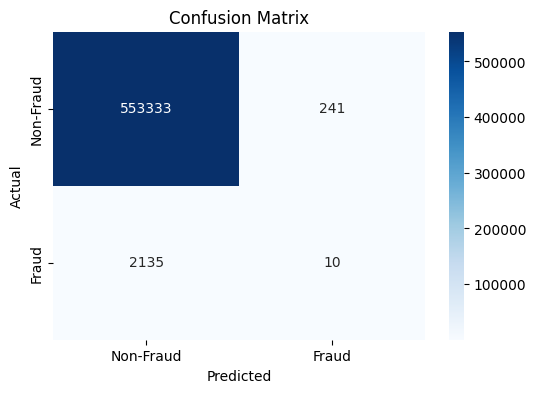

In [38]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Fraud', 'Fraud'], yticklabels=['Non-Fraud', 'Fraud'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


## ROC Curve

(Reciever Operating Characteristic)

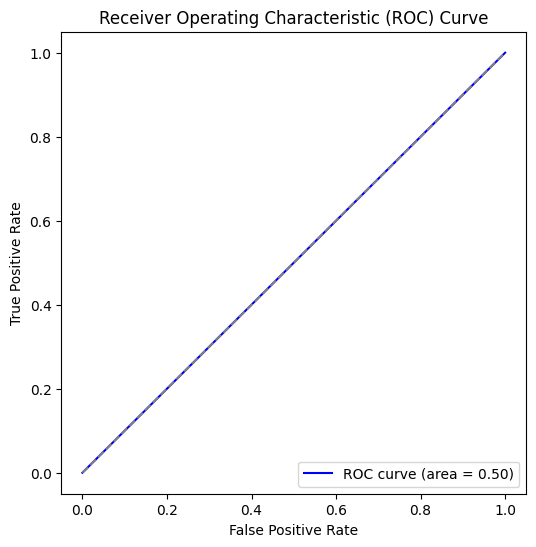

In [39]:
from sklearn.metrics import roc_curve, auc

# Get the false positive rate, true positive rate, and thresholds
fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(x_test)[:, 1])
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, color='blue', label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


## Precision-Recall Curve

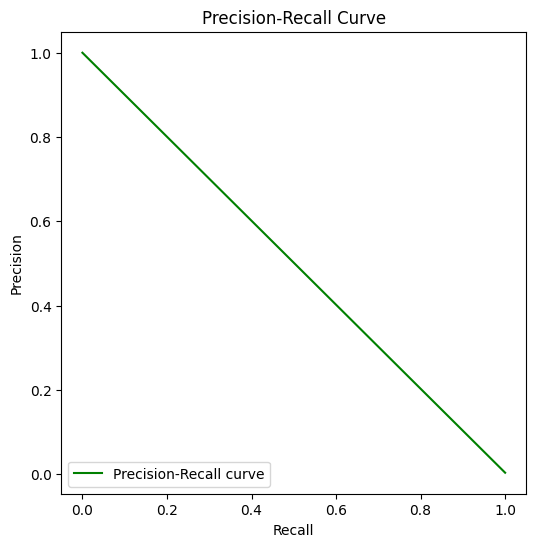

In [40]:
from sklearn.metrics import precision_recall_curve

# Get the precision, recall, and thresholds
precision, recall, thresholds = precision_recall_curve(y_test, model.predict_proba(x_test)[:, 1])

# Plot Precision-Recall curve
plt.figure(figsize=(6, 6))
plt.plot(recall, precision, color='green', label='Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.show()


#  **Random Forest**

In [41]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# rf_model = RandomForestClassifier(random_state=42)
rf_model = RandomForestClassifier(n_estimators=50, max_depth=10, random_state=42, n_jobs=-1)
rf_model.fit(x_train_balanced, y_train_balanced)

# Predict on the test set
y_pred = rf_model.predict(x_test)

# Evaluate model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Accuracy: 0.9707028192305823

Confusion Matrix:
 [[537830  15744]
 [   537   1608]]

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.97      0.99    553574
           1       0.09      0.75      0.16      2145

    accuracy                           0.97    555719
   macro avg       0.55      0.86      0.58    555719
weighted avg       1.00      0.97      0.98    555719



## Visualization - Random Forest (Feature Importance)

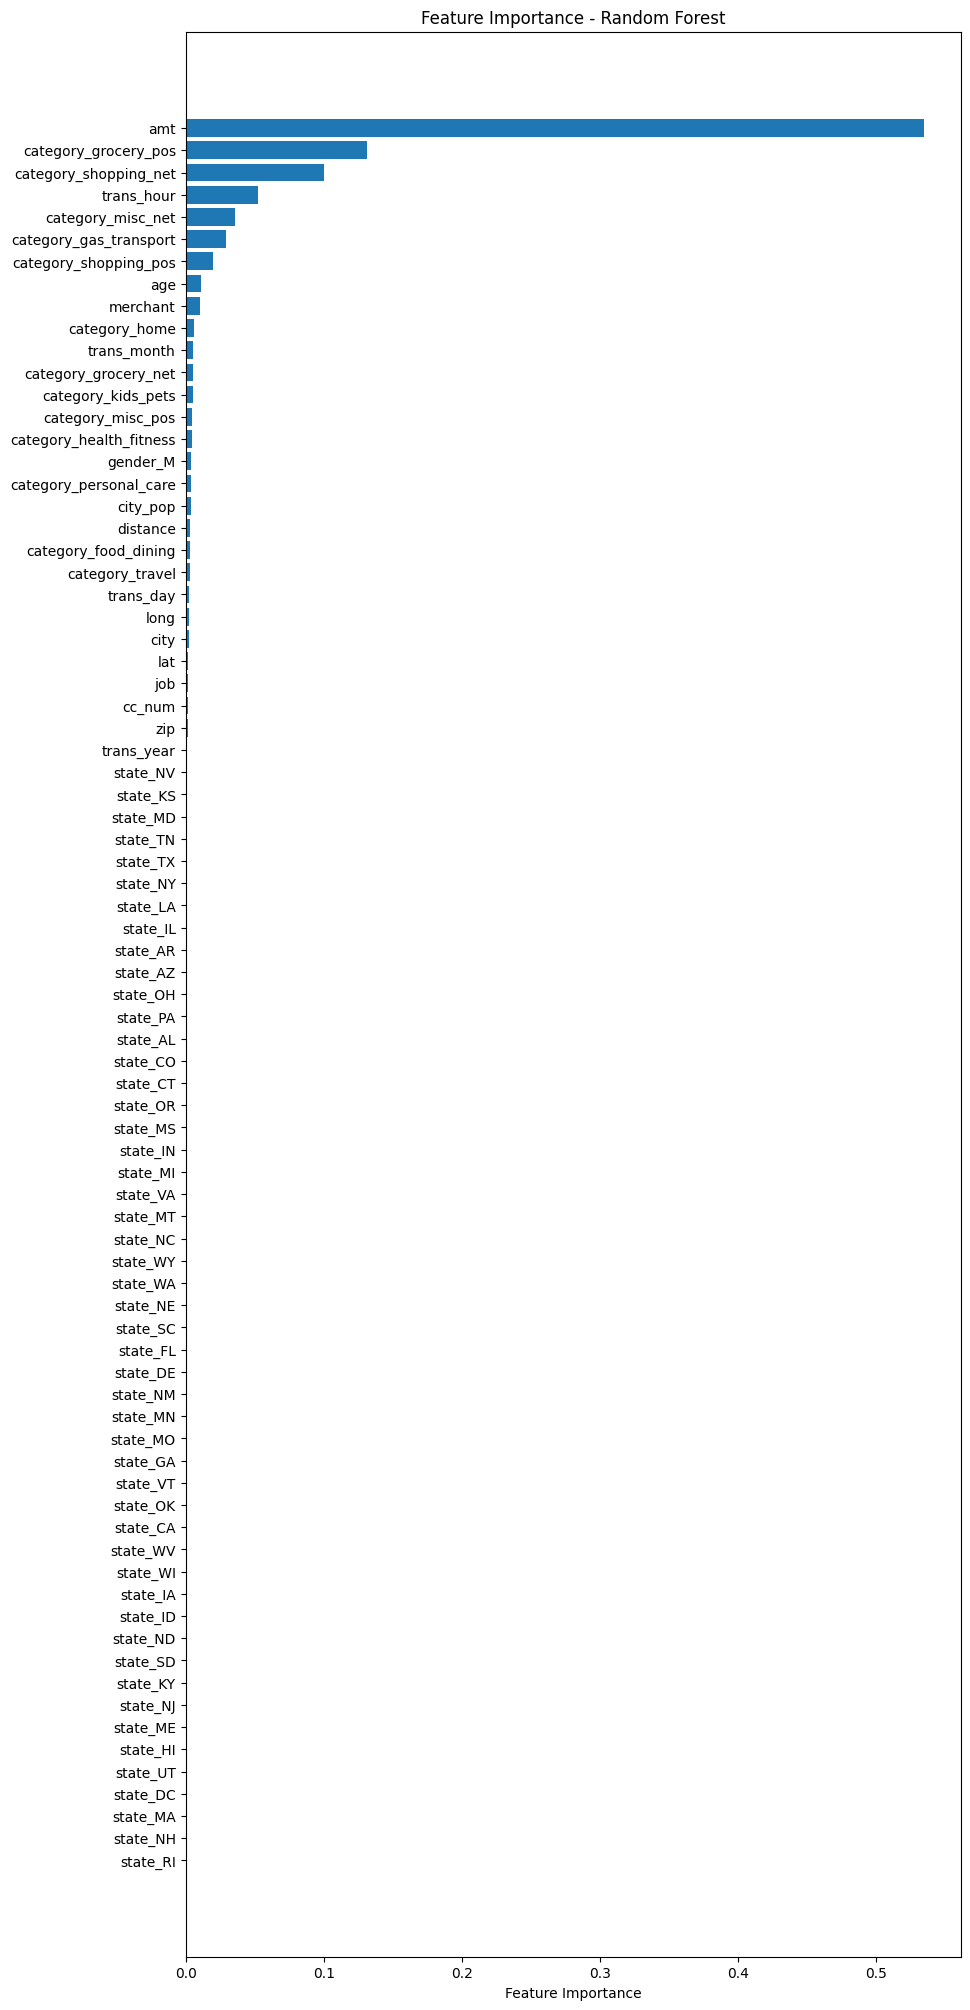

In [42]:
# Plot feature importance
plt.figure(figsize=(10, 25))
features = x_train.columns
importances = rf_model.feature_importances_
indices = np.argsort(importances)

plt.barh(range(len(indices)), importances[indices], align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Feature Importance')
plt.title('Feature Importance - Random Forest')
plt.show()


# Test Area

In [43]:
print(f"Training features: {x_train.columns}")
print(f"Test features: {x_test.columns}")

Training features: Index(['cc_num', 'merchant', 'amt', 'city', 'zip', 'lat', 'long', 'city_pop',
       'job', 'trans_hour', 'trans_day', 'trans_month', 'trans_year', 'age',
       'distance', 'category_food_dining', 'category_gas_transport',
       'category_grocery_net', 'category_grocery_pos',
       'category_health_fitness', 'category_home', 'category_kids_pets',
       'category_misc_net', 'category_misc_pos', 'category_personal_care',
       'category_shopping_net', 'category_shopping_pos', 'category_travel',
       'gender_M', 'state_AL', 'state_AR', 'state_AZ', 'state_CA', 'state_CO',
       'state_CT', 'state_DC', 'state_DE', 'state_FL', 'state_GA', 'state_HI',
       'state_IA', 'state_ID', 'state_IL', 'state_IN', 'state_KS', 'state_KY',
       'state_LA', 'state_MA', 'state_MD', 'state_ME', 'state_MI', 'state_MN',
       'state_MO', 'state_MS', 'state_MT', 'state_NC', 'state_ND', 'state_NE',
       'state_NH', 'state_NJ', 'state_NM', 'state_NV', 'state_NY', 'state_OH',
    

In [44]:
# Compare columns of x_train and x_test
train_columns = set(x_train.columns)
test_columns = set(x_test.columns)

# Find differences
missing_in_test = train_columns - test_columns  # Columns in x_train but not in x_test
missing_in_train = test_columns - train_columns  # Columns in x_test but not in x_train

# Print results
if not missing_in_test and not missing_in_train:
    print("Both x_train and x_test have the same columns.")
else:
    if missing_in_test:
        print(f"Columns in x_train but missing in x_test: {missing_in_test}")
    if missing_in_train:
        print(f"Columns in x_test but missing in x_train: {missing_in_train}")

Both x_train and x_test have the same columns.


# Visualization